In [1]:
# importing libraries
from langdetect import detect
from googletrans import Translator


from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.util import ngrams
# import warnings
# warnings.filterwarnings('ignore')
import pandas as pd

import contractions
from autocorrect import Speller
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import contractions
import yake
from rake_nltk import Rake
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Problem Statement

**The problem was to find whether the customers are happy or not with the product.**

# Data Gathering

In [2]:
df = pd.read_csv("all_kindle_review .csv")
df.head(1)

,Unnamed: 0.1,Unnamed: 0,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,11539,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1283385600


### Initial Preprocessing

In [3]:
# taking only relevent features
df = df[["summary","reviewText","rating"]]
df.head(3)

,summary,reviewText,rating
0,Entertaining But Average,"Jace Rankin may be short, but he's nothing to ...",3
1,Terrific menage scenes!,Great short read. I didn't want to put it dow...,5
2,Snapdragon Alley,I'll start by saying this is the first of four...,3


In [12]:
# I am working on the local machine. That's why I am extracting only 2000 rows
df1 = df.sample(2000).reset_index(drop = True)
df1.head(1)

,summary,reviewText,rating
0,The Unmasking of Lady Loveless,This is a very short novella . Lord Alexander ...,4


In [13]:
# Checking the language of the text
def lang_dect(data):
    lang = detect(data)
    return lang
s = pd.Series(df1["reviewText"].apply(lang_dect))
s.unique()

array(['en', 'af', 'de'], dtype=object)

In [14]:
# defining the function for translating all reviews into english
def lang_translate(data):
    translor = Translator()
    tr_text = translor.translate(data,dest="en")
    return tr_text.text

In [15]:
# the translator translate only 5000 words at once that's why i write a code by spliting the text
lst = []
for i in df1["reviewText"].values:
    if len(i) > 5000:
        lst.append(lang_translate(i[:5000])+ " "+ lang_translate(i[5000:]))
    else:
        lst.append(lang_translate(i))

In [16]:
df1["reviews"] = lst
df1.head()

,summary,reviewText,rating,reviews
0,The Unmasking of Lady Loveless,This is a very short novella . Lord Alexander ...,4,This is a very short novella . Lord Alexander ...
1,Only made me want to re-read the original,"Pride and Prejudicemash-ups, retellings, seque...",1,"Pride and Prejudicemash-ups, retellings, seque..."
2,A fun romp through the universe,I thoroughly enjoyed this ebook. In the vein o...,5,I thoroughly enjoyed this ebook. In the vein o...
3,Great reading,"Enjoyed reading this book, Robert Vaughan is ...",5,"Enjoyed reading this book, Robert Vaughan is ..."
4,A Sweet Christian Romance,The CHRISTMAS VILLAGE MIRACLE by Teresa Lily i...,3,The CHRISTMAS VILLAGE MIRACLE by Teresa Lily i...


In [17]:
# as we translate the reviews so we will remove the reviewText feature
df1.drop("reviewText",axis = 1, inplace = True)

# EDA

In [19]:
# ngrams 
def splitting_text(data):
    tokens = data.split()
    return tokens

def ngram_extract(data,ngram_range):
    tokens = splitting_text(data)
    ngram = ngrams(tokens,ngram_range)
    ngram_lst = []
    for i in ngram:
        ngram_lst.append(" ".join(i))
    return ngram_lst

In [20]:
unigram = df1["reviews"].apply(lambda x: ngram_extract(x,1))
unigram

0       [This, is, a, very, short, novella, ., Lord, A...
1       [Pride, and, Prejudicemash-ups,, retellings,, ...
2       [I, thoroughly, enjoyed, this, ebook., In, the...
3       [Enjoyed, reading, this, book,, Robert, Vaugha...
4       [The, CHRISTMAS, VILLAGE, MIRACLE, by, Teresa,...
                              ...                        
1995    [If, you, have, been, cheated, on,, read, this...
1996    [I, enjoyed, the, story, line, but, did, not, ...
1997    [It's, ok,, I, downloaded, it, because, it, wa...
1998    [Who, would, have, known, that, to, win, the, ...
1999    [Hawke, and, Dancer, finally, meet, and, the, ...
Name: reviews, Length: 2000, dtype: object

In [21]:
bigram = df1["reviews"].apply(lambda x: ngram_extract(x,2))
bigram

0       [This is, is a, a very, very short, short nove...
1       [Pride and, and Prejudicemash-ups,, Prejudicem...
2       [I thoroughly, thoroughly enjoyed, enjoyed thi...
3       [Enjoyed reading, reading this, this book,, bo...
4       [The CHRISTMAS, CHRISTMAS VILLAGE, VILLAGE MIR...
                              ...                        
1995    [If you, you have, have been, been cheated, ch...
1996    [I enjoyed, enjoyed the, the story, story line...
1997    [It's ok,, ok, I, I downloaded, downloaded it,...
1998    [Who would, would have, have known, known that...
1999    [Hawke and, and Dancer, Dancer finally, finall...
Name: reviews, Length: 2000, dtype: object

In [22]:
trigram = df1["reviews"].apply(lambda x: ngram_extract(x,3))
trigram

0       [This is a, is a very, a very short, very shor...
1       [Pride and Prejudicemash-ups,, and Prejudicema...
2       [I thoroughly enjoyed, thoroughly enjoyed this...
3       [Enjoyed reading this, reading this book,, thi...
4       [The CHRISTMAS VILLAGE, CHRISTMAS VILLAGE MIRA...
                              ...                        
1995    [If you have, you have been, have been cheated...
1996    [I enjoyed the, enjoyed the story, the story l...
1997    [It's ok, I, ok, I downloaded, I downloaded it...
1998    [Who would have, would have known, have known ...
1999    [Hawke and Dancer, and Dancer finally, Dancer ...
Name: reviews, Length: 2000, dtype: object

In [23]:
# cheking the most frequent trigrams
final_trigrams = []
for i in trigram:
    final_trigrams.extend(i)
cnt = Counter(final_trigrams).most_common(25)
cnt

[('a lot of', 110),
 ('This is a', 81),
 ('I would have', 70),
 ('one of the', 65),
 ('to be a', 57),
 ('the rest of', 55),
 ('it was a', 55),
 ('in love with', 53),
 ('I have read', 53),
 ('of the book', 51),
 ('the first book', 50),
 ('This was a', 49),
 ('This book was', 48),
 ('I liked the', 48),
 ('could have been', 48),
 ('of the story', 46),
 ('this is a', 46),
 ('rest of the', 45),
 ('this book was', 44),
 ('this book is', 43),
 ('I did not', 43),
 ('some of the', 41),
 ('was a good', 41),
 ('I really enjoyed', 39),
 ('a couple of', 39)]

##### So we can see that most of the reviews are positive

### word cloud

In [24]:
def word_cloud(data,column):
    df_ = data[column].str.cat(sep = " ")
    text = " ".join([i for i in df_.split()])
    wcloud = WordCloud(width = 700,height = 500, background_color= "linen").generate(text)
    plt.figure(figsize = (10,10))
    plt.imshow(wcloud)
    plt.axis("off")
    plt.show()

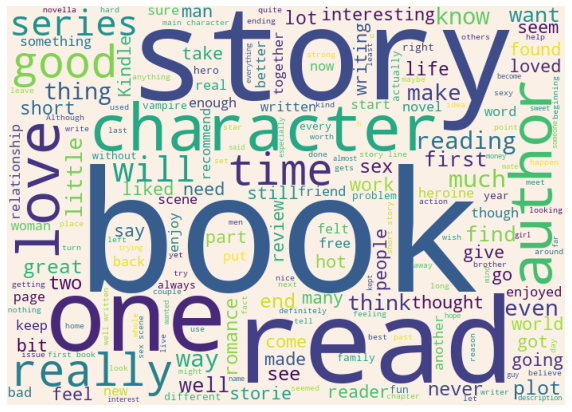

In [25]:
word_cloud(df1,"reviews")

###### here we can see the mostly reviews are good 

### Key phrase extrection

In [26]:
def yake_extractor(data):
    key_ext = yake.KeywordExtractor()
    keywords = key_ext.extract_keywords(data) # give (kewword, score) in a tuple
    key_lst = []
    for i in keywords:
        key_lst.append(i[0])
    return key_lst


In [27]:
keywords = df1["reviews"].apply(yake_extractor)
all_kw = []
for i in keywords:
    all_kw.extend(i)
cnt = Counter(all_kw).most_common(100)
cnt

[('book', 768),
 ('story', 565),
 ('read', 543),
 ('good', 259),
 ('characters', 244),
 ('books', 230),
 ('love', 197),
 ('reading', 178),
 ('author', 169),
 ('series', 165),
 ('short', 153),
 ('enjoyed', 137),
 ('time', 135),
 ('great', 129),
 ('written', 98),
 ('interesting', 90),
 ('stories', 88),
 ('sex', 87),
 ('romance', 85),
 ('loved', 79),
 ('short story', 79),
 ('character', 78),
 ('thought', 75),
 ('Kindle', 75),
 ('plot', 73),
 ('free', 65),
 ('recommend', 60),
 ('end', 56),
 ('writing', 55),
 ('hot', 54),
 ('bit', 54),
 ('story line', 54),
 ('lot', 53),
 ('enjoy', 53),
 ('found', 52),
 ('find', 52),
 ('life', 51),
 ('put', 51),
 ('work', 50),
 ('line', 50),
 ('fun', 47),
 ('people', 46),
 ('bad', 45),
 ('stars', 43),
 ('started', 43),
 ('worth', 41),
 ('scenes', 41),
 ('finish', 40),
 ('man', 40),
 ('ending', 40),
 ('times', 38),
 ('make', 38),
 ('hard', 38),
 ('heroine', 37),
 ('world', 37),
 ('made', 36),
 ('reviews', 36),
 ('review', 36),
 ('years', 36),
 ('feel', 35),
 

In [28]:
# rake keywords
def rake_extract(data):
    k_extr = Rake()
    k_extr.extract_keywords_from_text(data)
    return k_extr.get_ranked_phrases()

In [29]:
keyword1 = df1["reviews"].apply(rake_extract)
all_kw1 = []
for i in keyword1:
    all_kw1.extend(i)
cnt = Counter(all_kw1).most_common(100)
cnt

[('book', 1174),
 ('story', 753),
 ('read', 743),
 ('one', 422),
 ('like', 362),
 ('characters', 338),
 ('love', 331),
 ('series', 303),
 ('author', 300),
 ('get', 283),
 ('would', 257),
 ('books', 248),
 ('time', 238),
 ('know', 234),
 ('way', 234),
 ('think', 211),
 ('reading', 205),
 ('much', 188),
 ('end', 184),
 ('find', 174),
 ('well', 172),
 ('could', 168),
 ('found', 160),
 ('want', 160),
 ('see', 158),
 ('good', 158),
 ('liked', 154),
 ('lot', 152),
 ('really', 148),
 ('sex', 144),
 ('thought', 143),
 ('even', 143),
 ('loved', 141),
 ('make', 140),
 ('plot', 131),
 ('enjoyed', 131),
 ('life', 129),
 ('going', 128),
 ('say', 127),
 ('sure', 120),
 ('also', 116),
 ('short', 112),
 ('got', 110),
 ('man', 106),
 ('however', 102),
 ('work', 101),
 ('go', 100),
 ('bit', 100),
 ('kindle', 100),
 ('made', 100),
 ('give', 98),
 ('put', 96),
 ('free', 95),
 ('writing', 94),
 ('heroine', 93),
 ('stories', 92),
 ('enjoy', 90),
 ('people', 89),
 ('though', 87),
 ('written', 86),
 ('world',

###### by seeing form both of the keyword extractors most of the reviews are looking positive

# Preprocessing
### Data Cleaning

In [30]:
# defining the function for removing spaces
def remove_spaces(data):
    clean_text = data.replace("\\n"," ").replace("\t"," ").replace("\\"," ")
    return clean_text

# defining the function for expanding text (can't to can not)
def expand_text(data):
    ex_text = contractions.fix(data)
    return ex_text

# defining the function for handling accented characters (Á to A)
def handling_accented(data):
    fix_text = unidecode(data)
    return fix_text

# defining the function for removing stopwords
stopword = stopwords.words("english") # gives a list of stopwords
stopword.remove("no") # removing neccessary stop words from list
stopword.remove("not")
stopword.remove("nor")

def clean_text(data):
    token = word_tokenize(data)
    clean_text = [i.lower() for i in token if (i not in punctuation) 
                  and (i.lower() not in stopword) and (i.isalpha()) and (len(i) > 2)]
    return clean_text

# defining the function for auto correction 
def auto_correct(data):
    spell = Speller(lang = "en")
    text = spell(data)
    return text

# defining the function for getting root words
def lemmatization(data):
    lem = WordNetLemmatizer()
    lst1 = []
    for i in data:
        lem_words = lem.lemmatize(i)
        lst1.append(lem_words)
    return " ".join(lst1)

In [31]:
df1["final_rev"] = df1["reviews"].apply(remove_spaces)
df1["final_rev"] = df1["final_rev"].apply(expand_text)
df1["final_rev"] = df1["final_rev"].apply(handling_accented)
df1["final_rev"] = df1["final_rev"].apply(clean_text)
df1["final_rev"] = df1["final_rev"].apply(lambda x: auto_correct(x) if isinstance(x, str) or isinstance(x, bytes) else x)
df1["final_rev"] = df1["final_rev"].apply(lemmatization)

In [32]:
# now we have the final reviews so we will drop the reviews feature
df1.drop("reviews", axis = 1,inplace = True)

### making labels on the basis of rating (supportive feature)

In [35]:
# as I have seen where rating is from 1 to 3 where summary is not good.
# So from 1-3 rating users are not satisfied with the book that's why i give 0 for them
df1["target"] = np.where(df1["rating"] <= 3, 0,1 )
df1.sample(5)

,summary,rating,final_rev,target
1095,Good,3,actually like short kept attention story flowe...,0
989,Truly a bad read,1,story line speak whole situation different vie...,0
342,( Out of Uniform) 1. Heat of the Moment-Red-Ho...,5,john garrett circled around year neither thoug...,1
1913,"GOOD HERO, GOOD STORIES",5,thoroughly enjoyed meeting thorndyke following...,1
916,Juvenile,2,finished reading book although nearly quit mul...,0


In [36]:
# dropping the rating and summary featuer now
df1.drop(["rating","summary"], inplace = True, axis = 1)

# Word2Vec

In [37]:
# making input for model and saving the model
inputs = df1.final_rev.apply(clean_text).tolist()
model = Word2Vec(inputs,window = 6, min_count = 2, epochs = 2, vector_size = 200, sg = 0)
model.save("word2vec.model") #to save the model

In [38]:
def vectorize(list_of_docs,model):
    feature = []
    names   = []
    for review in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for word in review:
            if word in model.wv:
                try:
                    vectors.append(model.wv["word"])
                    names.append(word)
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis = 0)
            feature.append(avg_vec)
        else:
            feature.append(zero_vector)
    return feature, list(set(names))
    

In [49]:
vectorized_docs, feature_names = vectorize(inputs,model)
emd_x = np.array(vectorized_docs)

In [50]:
# So now we have the data for our model 
x = emd_x
y = df1["target"]

In [67]:
# train test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42,stratify=y)

# Model Training

In [68]:
model = GaussianNB()
model.fit(x_train,y_train)

GaussianNB()

In [69]:
# evaluatioin
pred = model.predict(x_train)
acc = accuracy_score(y_train,pred)
clf = classification_report(y_train,pred)
print("The accuracy of the model is: ",acc)
print("\n")
print("The classifiaction report:\n",clf)

The accuracy of the model is:  0.5171641791044777


The classifiaction report:
               precision    recall  f1-score   support

           0       0.51      0.95      0.66       673
           1       0.61      0.09      0.15       667

    accuracy                           0.52      1340
   macro avg       0.56      0.52      0.41      1340
weighted avg       0.56      0.52      0.41      1340



In [70]:
pred1 = model.predict(x_test)
acc1 = accuracy_score(y_test,pred1)
clf1 = classification_report(y_test,pred1)
print("The accuracy of the model is: ",acc1)
print("\n")
print("The classifiaction report:\n",clf1)

The accuracy of the model is:  0.503030303030303


The classifiaction report:
               precision    recall  f1-score   support

           0       0.50      0.90      0.65       332
           1       0.50      0.10      0.17       328

    accuracy                           0.50       660
   macro avg       0.50      0.50      0.41       660
weighted avg       0.50      0.50      0.41       660



In [71]:
from sklearn.neighbors import KNeighborsClassifier
model1 = KNeighborsClassifier()
model1.fit(x_train,y_train)

KNeighborsClassifier()

In [72]:
pred = model1.predict(x_train)
acc = accuracy_score(y_train,pred)
clf = classification_report(y_train,pred)
print("The accuracy of the model is: ",acc)
print("\n")
print("The classifiaction report:\n",clf)

The accuracy of the model is:  0.5850746268656717


The classifiaction report:
               precision    recall  f1-score   support

           0       0.58      0.63      0.61       673
           1       0.59      0.54      0.56       667

    accuracy                           0.59      1340
   macro avg       0.59      0.58      0.58      1340
weighted avg       0.59      0.59      0.58      1340



In [73]:
pred1 = model1.predict(x_test)
acc1 = accuracy_score(y_test,pred1)
clf1 = classification_report(y_test,pred1)
print("The accuracy of the model is: ",acc1)
print("\n")
print("The classifiaction report:\n",clf1)

The accuracy of the model is:  0.5


The classifiaction report:
               precision    recall  f1-score   support

           0       0.50      0.52      0.51       332
           1       0.50      0.48      0.49       328

    accuracy                           0.50       660
   macro avg       0.50      0.50      0.50       660
weighted avg       0.50      0.50      0.50       660



In [74]:
from xgboost import XGBClassifier
model2 = XGBClassifier()
model2.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [75]:
pred = model2.predict(x_train)
acc = accuracy_score(y_train,pred)
clf = classification_report(y_train,pred)
print("The accuracy of the model is: ",acc)
print("\n")
print("The classifiaction report:\n",clf)

The accuracy of the model is:  0.6231343283582089


The classifiaction report:
               precision    recall  f1-score   support

           0       0.65      0.55      0.59       673
           1       0.61      0.70      0.65       667

    accuracy                           0.62      1340
   macro avg       0.63      0.62      0.62      1340
weighted avg       0.63      0.62      0.62      1340



In [76]:
pred1 = model2.predict(x_test)
acc1 = accuracy_score(y_test,pred1)
clf1 = classification_report(y_test,pred1)
print("The accuracy of the model is: ",acc1)
print("\n")
print("The classifiaction report:\n",clf1)

The accuracy of the model is:  0.48787878787878786


The classifiaction report:
               precision    recall  f1-score   support

           0       0.49      0.39      0.43       332
           1       0.49      0.59      0.53       328

    accuracy                           0.49       660
   macro avg       0.49      0.49      0.48       660
weighted avg       0.49      0.49      0.48       660



In [ ]:
So, we can use XGBoost for this model, as it is giving high accuracy and good f1 score also.